In [198]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

def make_bins(xlim,dx):
    Edges_x = np.arange(xlim[0],xlim[1]+dx,dx)
    Bins_x = Edges_x[:-1]+dx/2
    return Edges_x,Bins_x

In [199]:
path = '../DataFrames/df_road.csv'
df_road = pd.read_csv(path)

In [200]:
#normalize total to # of year of availability 

#this is a little tricky since accident data is not available for every year aadf is

#for now only include roads with the full 21+ years of coverage, with no gaps, and with year end >= 2018

yend_lim = 2018
N_year_min = 21
gap_min = 1

Igap = df_road.Max_year_gap >= 1
In = df_road.N_year >= 21
Iyend = df_road.Year_end >= 2018

In [201]:
V_bike_min = 1000 #minimum value of aadf_Pedal_cycle to include

I = (df_road.aadf_Pedal_cycles >= V_bike_min) & Igap & In & Iyend
df_road_sub = df_road.loc[I,:].copy()

In [202]:
#make some new features from existing ones
    #bike volume frac of all motor vehicle volume (bike_over_all)
    #bus volume/all motor vehicle (bus_over_all)
    
df_road_sub['bike_over_all'] = df_road_sub.aadf_Pedal_cycles.values/df_road_sub.aadf_All_motor_vehicles.values
df_road_sub['bus_over_all'] = df_road_sub.aadf_Buses_and_coaches.values/df_road_sub.aadf_All_motor_vehicles.values

In [203]:
#look at mean, variance, and median of total_norm
mean_total_norm = df_road_sub.total_norm.mean()
var_total_norm = df_road_sub.total_norm.var()
std_total_norm = np.sqrt(var_total_norm)
med_total_norm = df_road_sub.total_norm.median()
print('total_norm stats: \n mean = %.4f \n variance = %.4f \n stdev = %.4f \n median = %.4f'%(mean_total_norm,var_total_norm,std_total_norm,med_total_norm))

total_norm stats: 
 mean = 0.0167 
 variance = 0.0003 
 stdev = 0.0163 
 median = 0.0120


In [204]:
#look at mean, variance, and median of total_norm
mean_total = df_road_sub.total.mean()
var_total = df_road_sub.total.var()
std_total = np.sqrt(var_total)
med_total = df_road_sub.total.median()
print('total_norm stats: \n mean = %.4f \n variance = %.4f \n stdev = %.4f \n median = %.4f'%(mean_total,var_total,std_total,med_total))

total_norm stats: 
 mean = 37.6738 
 variance = 1306.3985 
 stdev = 36.1441 
 median = 28.0000


- both the normalized total and the total are exponential distributions (mean = stdev)
- this probably means that the total is highly correlated with bike traffic as expected (but not a given)

In [205]:
from scipy.optimize import curve_fit

def exp_dist(x,A,lam):
    return A*lam*np.exp(-lam*x)

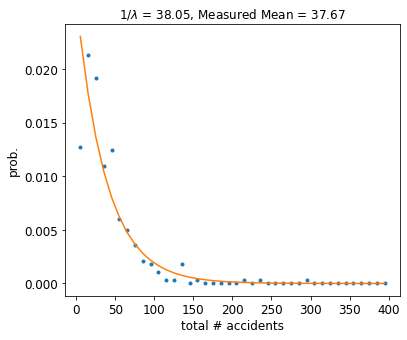

In [178]:
#fit total histogram to exponential

tot_r = (0,400)
dtot = 10
e_tot,b_tot = make_bins(tot_r,dtot)
Ht,_ = np.histogram(df_road_sub.total.values,bins=e_tot)
Y_tot_dist = Ht/Ht.sum()*1/dtot

lam_r = [0.99/mean_total,1.01/mean_total]
A_r = [1.0,1.00001]
coeff_total,_ = curve_fit(exp_dist,b_tot,Y_tot_dist,bounds=[[A_r[0],lam_r[0]],[A_r[1],lam_r[1]]])

fig,ax = plt.subplots(figsize=(6,5))
#ax.bar(b_tot,Y_tot_dist)
ax.plot(b_tot,Y_tot_dist,marker='.',linestyle='none')
ax.plot(b_tot,exp_dist(b_tot,*coeff_total))
ax.set_xlabel('total # accidents',fontsize=12)
ax.set_ylabel('prob.',fontsize=12)
ax.set_title(r'1/$\lambda$ = %.2f, Measured Mean = %.2f'%(1/coeff_total[1],mean_total),
            fontsize=12)
ax.tick_params(labelsize=12)
plt.show()

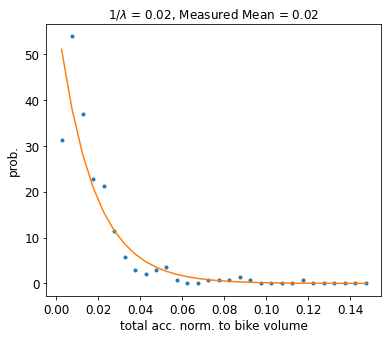

In [179]:
#fit total_norm histogram to exponential

tot_norm_r = (0,0.15)
dtot_norm = 0.005
e_tot_norm,b_tot_norm = make_bins(tot_norm_r,dtot_norm)
Ht_norm,_ = np.histogram(df_road_sub.total_norm.values,bins=e_tot_norm)
Y_tot_norm_dist = Ht_norm/Ht_norm.sum()*1/dtot_norm

lam_r = [0.99/mean_total_norm,1.01/mean_total_norm]
A_r = [1.0,1.00001]
coeff_total_norm,_ = curve_fit(exp_dist,b_tot_norm,Y_tot_norm_dist,bounds=[[A_r[0],lam_r[0]],[A_r[1],lam_r[1]]])

fig,ax = plt.subplots(figsize=(6,5))
#ax.bar(b_tot,Y_tot_dist)
ax.plot(b_tot_norm,Y_tot_norm_dist,marker='.',linestyle='none')
ax.plot(b_tot_norm,exp_dist(b_tot_norm,*coeff_total_norm))
ax.set_xlabel('total acc. norm. to bike volume',fontsize=12)
ax.set_ylabel('prob.',fontsize=12)
ax.set_title(r'1/$\lambda$ = %.2f, Measured Mean = %.2f'%(1/coeff_total_norm[1],mean_total_norm),
            fontsize=12)
ax.tick_params(labelsize=12)
plt.show()

#### Look into the possible need to normalize by the sampling density of a traffic counter
- here use averaged distance_to_cp

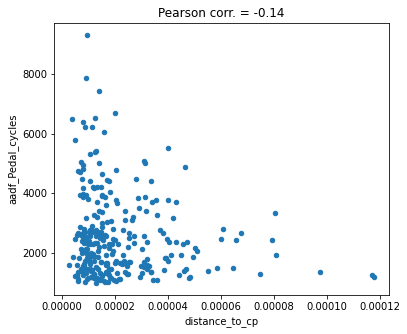

In [208]:
#scatter plot with correlation of 

fig,ax = plt.subplots(figsize=(6,5))

df_road_sub.plot.scatter('distance_to_cp','aadf_Pedal_cycles',ax=ax)
pear_corr = df_road_sub[['aadf_Pedal_cycles','distance_to_cp']].corr()
ax.set_title('Pearson corr. = %.2f'%pear_corr.loc['aadf_Pedal_cycles','distance_to_cp'])

plt.show()

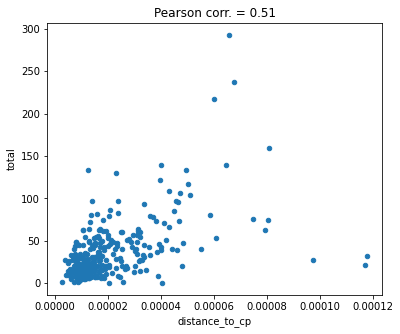

In [212]:
#scatter plot with correlation of 

fig,ax = plt.subplots(figsize=(6,5))

df_road_sub.plot.scatter('distance_to_cp','total',ax=ax)
pear_corr = df_road_sub[['total','distance_to_cp']].corr()
ax.set_title('Pearson corr. = %.2f'%pear_corr.loc['total','distance_to_cp'])

plt.show()

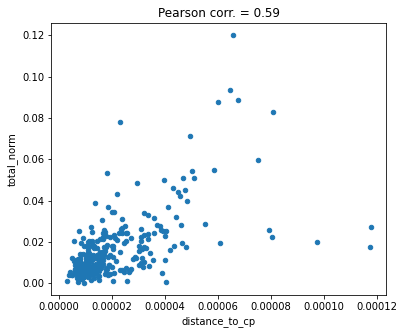

In [213]:
#scatter plot with correlation of 

fig,ax = plt.subplots(figsize=(6,5))

df_road_sub.plot.scatter('distance_to_cp','total_norm',ax=ax)
pear_corr = df_road_sub[['total_norm','distance_to_cp']].corr()
ax.set_title('Pearson corr. = %.2f'%pear_corr.loc['total_norm','distance_to_cp'])

plt.show()

#### Some more EDA

- the plot below shows that maybe a decision boundary can be drawn to highlight two class of roads
- the roads below the boundary are a safer class of road

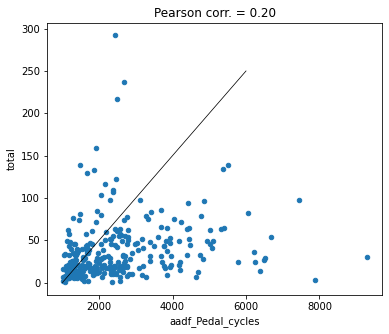

In [206]:
#scatter plot of total accidents vs. bike volume. Show pearson correlation

fig,ax = plt.subplots(figsize=(6,5))

b = 50/1000

xplt = np.linspace(1000,6000)
yplt = b*(xplt-1000)

df_road_sub.plot.scatter('aadf_Pedal_cycles','total',ax=ax)
pear_corr = df_road_sub[['total','aadf_Pedal_cycles']].corr()
ax.set_title('Pearson corr. = %.2f'%pear_corr.loc['total','aadf_Pedal_cycles'])
ax.plot(xplt,yplt,color='black',linewidth=0.75)

plt.show()

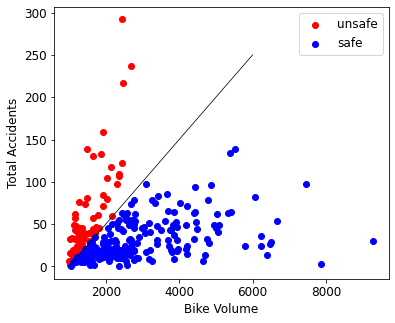

In [181]:
#test if implementing decision boundary correctly

def decis_bound(x_bike): #things above the line are unsafe, below are safe
    b = 50/1000
    return b*(x_bike-1000)

boundary = decis_bound(df_road_sub.aadf_Pedal_cycles.values)
I_unsafe = df_road_sub.total > boundary

labsize=12
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter(df_road_sub.loc[I_unsafe,'aadf_Pedal_cycles'].values,
           df_road_sub.loc[I_unsafe,'total'].values,color='red',label='unsafe')
ax.scatter(df_road_sub.loc[~I_unsafe,'aadf_Pedal_cycles'].values,
           df_road_sub.loc[~I_unsafe,'total'].values,color='blue',label='safe')
ax.plot(xplt,yplt,color='black',linewidth=0.75)

ax.set_ylabel('Total Accidents',fontsize=labsize)
ax.set_xlabel('Bike Volume',fontsize=labsize)
ax.legend(fontsize=labsize)
ax.tick_params(labelsize=labsize)
plt.show()

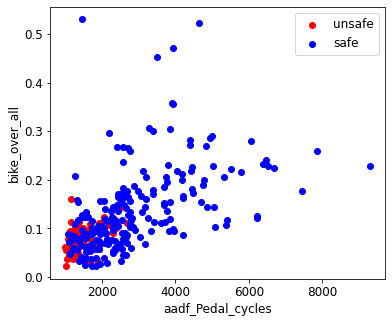

In [197]:
#using the decision boundary made above to color, now make scatter of some other features

x_var = 'aadf_Pedal_cycles'
y_var = 'bike_over_all'

labsize=12
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter(df_road_sub.loc[I_unsafe,x_var].values,
           df_road_sub.loc[I_unsafe,y_var].values,color='red',label='unsafe')
ax.scatter(df_road_sub.loc[~I_unsafe,x_var].values,
           df_road_sub.loc[~I_unsafe,y_var].values,color='blue',label='safe')
#ax.plot(xplt,yplt,color='black',linewidth=0.75)

ax.set_ylabel(y_var,fontsize=labsize)
ax.set_xlabel(x_var,fontsize=labsize)
ax.legend(fontsize=labsize)
ax.tick_params(labelsize=labsize)
plt.show()

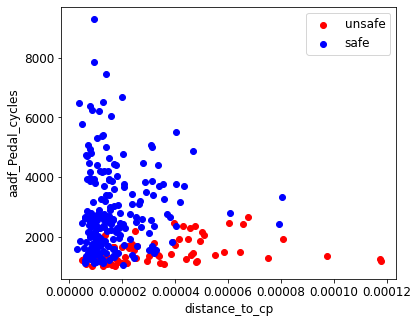

In [209]:
#using the decision boundary made above to color, now make scatter of some other features

y_var = 'aadf_Pedal_cycles'
x_var = 'distance_to_cp'

labsize=12
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter(df_road_sub.loc[I_unsafe,x_var].values,
           df_road_sub.loc[I_unsafe,y_var].values,color='red',label='unsafe')
ax.scatter(df_road_sub.loc[~I_unsafe,x_var].values,
           df_road_sub.loc[~I_unsafe,y_var].values,color='blue',label='safe')
#ax.plot(xplt,yplt,color='black',linewidth=0.75)

ax.set_ylabel(y_var,fontsize=labsize)
ax.set_xlabel(x_var,fontsize=labsize)
ax.legend(fontsize=labsize)
ax.tick_params(labelsize=labsize)
plt.show()

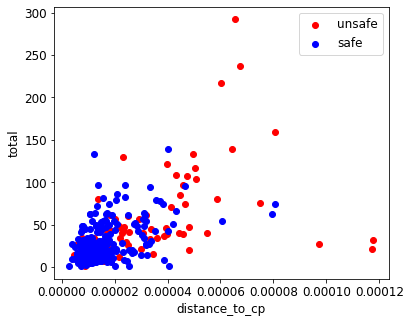

In [210]:
#using the decision boundary made above to color, now make scatter of some other features

y_var = 'total'
x_var = 'distance_to_cp'

labsize=12
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter(df_road_sub.loc[I_unsafe,x_var].values,
           df_road_sub.loc[I_unsafe,y_var].values,color='red',label='unsafe')
ax.scatter(df_road_sub.loc[~I_unsafe,x_var].values,
           df_road_sub.loc[~I_unsafe,y_var].values,color='blue',label='safe')
#ax.plot(xplt,yplt,color='black',linewidth=0.75)

ax.set_ylabel(y_var,fontsize=labsize)
ax.set_xlabel(x_var,fontsize=labsize)
ax.legend(fontsize=labsize)
ax.tick_params(labelsize=labsize)
plt.show()

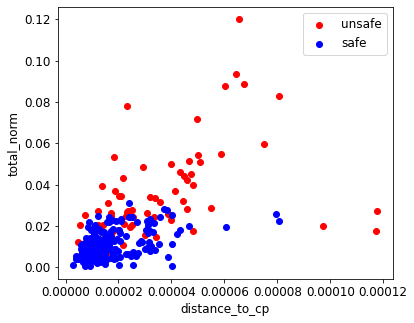

In [211]:
#using the decision boundary made above to color, now make scatter of some other features

y_var = 'total_norm'
x_var = 'distance_to_cp'

labsize=12
fig,ax = plt.subplots(figsize=(6,5))

ax.scatter(df_road_sub.loc[I_unsafe,x_var].values,
           df_road_sub.loc[I_unsafe,y_var].values,color='red',label='unsafe')
ax.scatter(df_road_sub.loc[~I_unsafe,x_var].values,
           df_road_sub.loc[~I_unsafe,y_var].values,color='blue',label='safe')
#ax.plot(xplt,yplt,color='black',linewidth=0.75)

ax.set_ylabel(y_var,fontsize=labsize)
ax.set_xlabel(x_var,fontsize=labsize)
ax.legend(fontsize=labsize)
ax.tick_params(labelsize=labsize)
plt.show()

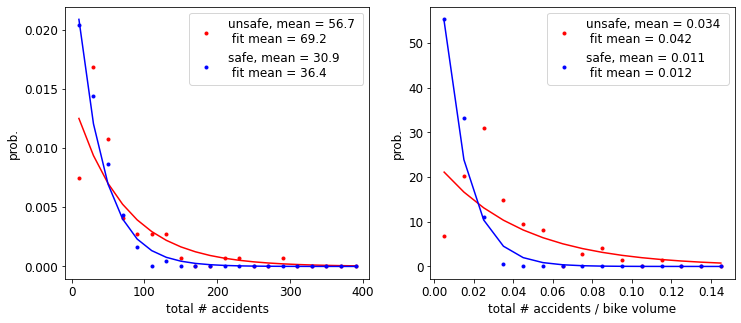

In [182]:
#make histograms of total distribution for both total and total_norm for safe and unsafe separately

Idecis = [None]*2
Idecis[0] = I_unsafe
Idecis[1] = ~I_unsafe
lab_decis = ['unsafe','safe']
c_decis = ['red','blue']

per_con = [0.8,1.2] #keep lambda value within these frac. of 1/(meausured mean)

tot_r = (0,400)
dtot = 20
e_tot,b_tot = make_bins(tot_r,dtot)
Nbtot = len(b_tot)

tot_norm_r = (0,0.15)
dtot_norm = 0.005*2
e_tot_norm,b_tot_norm = make_bins(tot_norm_r,dtot_norm)
Nbtot_norm = len(b_tot_norm)

Y_tot_dist = np.zeros((2,Nbtot))
coeff_tot = np.zeros((2,2))
mean_tot = np.zeros(2)

Y_tot_norm_dist = np.zeros((2,Nbtot_norm))
coeff_tot_norm = np.zeros((2,2))
mean_tot_norm = np.zeros(2)
for ii in range(2):
    Ht,_ = np.histogram(df_road_sub.loc[Idecis[ii],'total'].values,bins=e_tot)
    Y_tot_dist[ii] = Ht/Ht.sum()*1/dtot
    mean_tot[ii] = df_road_sub.loc[Idecis[ii],'total'].mean()
    lam_r = [per_con[0]/mean_tot[ii],per_con[1]/mean_tot[ii]]
    A_r = [1.0,1.00001]
    coeff_tot[ii],_ = curve_fit(exp_dist,b_tot,Y_tot_dist[ii],
                                bounds=[[A_r[0],lam_r[0]],[A_r[1],lam_r[1]]])
    
    Ht,_ = np.histogram(df_road_sub.loc[Idecis[ii],'total_norm'].values,bins=e_tot_norm)
    Y_tot_norm_dist[ii] = Ht/Ht.sum()*1/dtot_norm
    mean_tot_norm[ii] = df_road_sub.loc[Idecis[ii],'total_norm'].mean()
    lam_r = [per_con[0]/mean_tot_norm[ii],per_con[1]/mean_tot_norm[ii]]
    A_r = [1.0,1.00001]
    coeff_tot_norm[ii],_ = curve_fit(exp_dist,b_tot_norm,Y_tot_norm_dist[ii],
                                bounds=[[A_r[0],lam_r[0]],[A_r[1],lam_r[1]]])

  
labsize=12
fig,ax = plt.subplots(1,2,figsize=(2*6,5))

nn = 0
for ii in range(2):
    label = '%s, mean = %.1f \n fit mean = %.1f'%(lab_decis[ii],mean_tot[ii],1/coeff_tot[ii,1])
    ax[nn].plot(b_tot,Y_tot_dist[ii],marker='.',linestyle='none',color=c_decis[ii],label=label)
    ax[nn].plot(b_tot,exp_dist(b_tot,*coeff_tot[ii]),color=c_decis[ii])
ax[nn].set_xlabel('total # accidents',fontsize=labsize)
ax[nn].set_ylabel('prob.',fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)
ax[nn].legend(fontsize=labsize)
    
nn = 1
for ii in range(2):
    label = '%s, mean = %.3f \n fit mean = %.3f'%(lab_decis[ii],mean_tot_norm[ii],1/coeff_tot_norm[ii,1])
    ax[nn].plot(b_tot_norm,Y_tot_norm_dist[ii],marker='.',linestyle='none',color=c_decis[ii],label=label)
    ax[nn].plot(b_tot_norm,exp_dist(b_tot_norm,*coeff_tot_norm[ii]),color=c_decis[ii])
ax[nn].set_xlabel('total # accidents / bike volume',fontsize=labsize)
ax[nn].set_ylabel('prob.',fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)
ax[nn].legend(fontsize=labsize)
    
    
plt.show()

In [184]:
df_road_sub.bike_over_all.describe()

count    282.000000
mean       0.121959
std        0.080816
min        0.021528
25%        0.066987
50%        0.102150
75%        0.154732
max        0.530426
Name: bike_over_all, dtype: float64

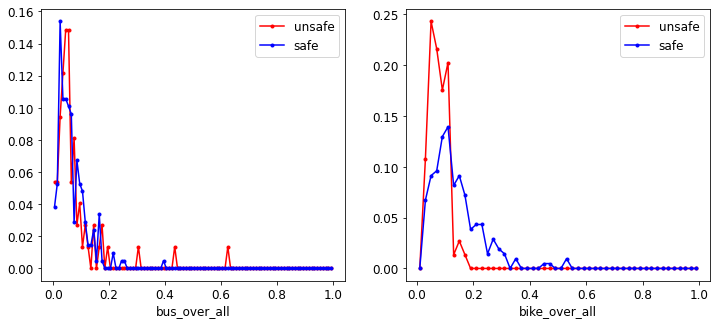

In [188]:
dbus = 0.01
bus_r = (0,1)
e_bus,b_bus = make_bins(bus_r,dbus)
Nb_bus = len(b_bus)

dbike = 0.02
bike_r = (0,1)
e_bike,b_bike = make_bins(bike_r,dbike)
Nb_bike = len(b_bike)

H_bus = np.zeros((2,Nb_bus))
H_bike = np.zeros((2,Nb_bike))
for ii in range(2):
    H_bus[ii],_ = np.histogram(df_road_sub.loc[Idecis[ii],'bus_over_all'],bins=e_bus)
    H_bike[ii],_ = np.histogram(df_road_sub.loc[Idecis[ii],'bike_over_all'],bins=e_bike)
    
norm = True

fig,ax=plt.subplots(1,2,figsize=(2*6,5))

nn = 0
for ii in range(2):
    if norm:
        c = H_bus[ii].sum()
    else:
        c = 1
    ax[nn].plot(b_bus,H_bus[ii]/c,marker='.',color=c_decis[ii],label=lab_decis[ii])
    
ax[nn].set_xlabel('bus_over_all',fontsize=labsize)
ax[nn].legend(fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)

nn = 1
for ii in range(2):
    if norm:
        c = H_bike[ii].sum()
    else:
        c = 1
    ax[nn].plot(b_bike,H_bike[ii]/c,marker='.',color=c_decis[ii],label=lab_decis[ii])
    
ax[nn].set_xlabel('bike_over_all',fontsize=labsize)
ax[nn].legend(fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)
    
plt.show()

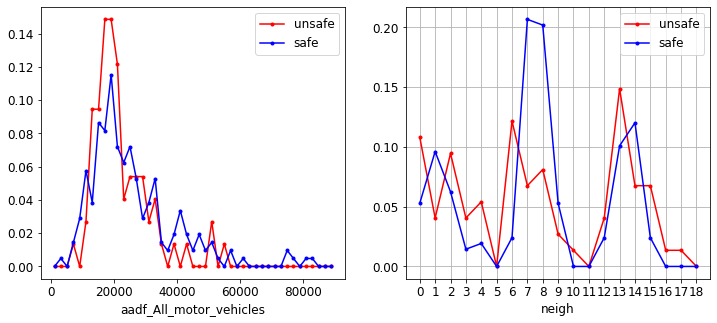

In [195]:
dall = 2e3
all_r = (0,9e4)
e_all,b_all = make_bins(all_r,dall)
Nb_all = len(b_all)

dneigh = 1
neigh_r = (-0.5,18.5)
e_neigh,b_neigh = make_bins(neigh_r,dneigh)
Nb_neigh = len(b_neigh)

H_all = np.zeros((2,Nb_all))
H_neigh = np.zeros((2,Nb_neigh))
for ii in range(2):
    H_all[ii],_ = np.histogram(df_road_sub.loc[Idecis[ii],'aadf_All_motor_vehicles'],bins=e_all)
    H_neigh[ii],_ = np.histogram(df_road_sub.loc[Idecis[ii],'neigh'],bins=e_neigh)
    
norm = True

fig,ax=plt.subplots(1,2,figsize=(2*6,5))

nn = 0
for ii in range(2):
    if norm:
        c = H_all[ii].sum()
    else:
        c = 1
    ax[nn].plot(b_all,H_all[ii]/c,marker='.',color=c_decis[ii],label=lab_decis[ii])
    
ax[nn].set_xlabel('aadf_All_motor_vehicles',fontsize=labsize)
ax[nn].legend(fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)

nn = 1
for ii in range(2):
    if norm:
        c = H_neigh[ii].sum()
    else:
        c = 1
    ax[nn].plot(b_neigh,H_neigh[ii]/c,marker='.',color=c_decis[ii],label=lab_decis[ii])
    
ax[nn].set_xlabel('neigh',fontsize=labsize)
ax[nn].legend(fontsize=labsize)
ax[nn].tick_params(labelsize=labsize)
ax[nn].set_xticks(b_neigh)
ax[nn].grid('on')
    
plt.show()